In [1]:
import json
import glob
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load data

In [2]:
# Align the logs for each run (*.csv) with the corresponding log containing the hyperparameters (optimizationLogs*.json)
def getLogPairs(alg):
    optimizationLogs = sorted(glob.glob(f"./{alg}/optimizationLogs*.json"))
    runLogs = sorted(glob.glob(f"./{alg}/*.csv"), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    
    logPairs = []
    logNum = 0
    for log in optimizationLogs:
        for line in open(log).readlines():
            logPairs.append((pd.read_csv(runLogs[logNum], delimiter="\t"), json.loads(line)))
            logNum += 1
    return logPairs

def computeScore(runLog):
    return (runLog["WaypointsVisited"] - runLog["Steps"] / 1000.).mean()

def getMapName(path):
    rawName = os.path.splitext(os.path.basename(path))[0]
    # We now have ptsp_map$ID$, remove the ptsp_
    return rawName.split("_")[1]

Each optimizationLog.json contains the parameters chosen by the bayesian optimization, as well as the score that resulted from the parameter choice. The *.csv file contains the data that was collected when running the algorithm with the corresponding parameter choice. We've used the getLogPairs function to align these two things, to make sure that the alignment was correct we compute the score from the .csv file and compare it with the score stored in the .json file

In [3]:
algorithms = ["MS-MCTS", "QD-MCTS", "S-MCTS", "VanillaGA", "VanillaMCTS"]
    
# Read data
algLogDict = {}
for alg in algorithms:
    logPairs = getLogPairs(alg)

    # Safety Check that the alignment worked
    # We check that the scores logged in the optimization log match the score computed from the run log
    for runLog, optLog in logPairs:
        if abs(optLog["target"] - computeScore(runLog)) > 0.00001:
            print("Error scores do not align!")

    algLogDict[alg] = logPairs

# Visualize the best parameter choices

In [4]:
bestRunsDict = {}
for alg in algorithms:
    logPairs = algLogDict[alg]
    # Find the run with the highest score
    bestRunLog, bestOptLog = max(logPairs, key=lambda pair: pair[1]["target"])
    print(f"Best score for {alg}: {bestOptLog['target']}")
    print(f"Best parameters for {alg}: {bestOptLog['params']}")
    bestRunsDict[f"{alg}\n{bestOptLog['target']:.2f}"] = bestRunLog

Best score for MS-MCTS: 4.53075
Best parameters for MS-MCTS: {'cellSize': 5.0281035350264, 'er': 9.359425031432846, 'rd': 22.141178093007678, 'steps': 559.4797441359474}
Best score for QD-MCTS: 7.003029999999998
Best parameters for QD-MCTS: {'highER': 19.564505347263143, 'lowER': 20.0, 'rd': 35.79060885649038, 'steps': 466.4566560402194}
Best score for S-MCTS: 5.063550000000001
Best parameters for S-MCTS: {'cellSize': 29.397034606386566, 'er': 13.81435314389922, 'rd': 39.716477585218485, 'steps': 513.1280037445927}
Best score for VanillaGA: 5.82191
Best parameters for VanillaGA: {'gl': 39.35328567880911, 'mr': 0.01, 'ps': 198.0172255671554}
Best score for VanillaMCTS: 6.8343
Best parameters for VanillaMCTS: {'er': 7.805778718651435, 'rd': 34.894420897604384}


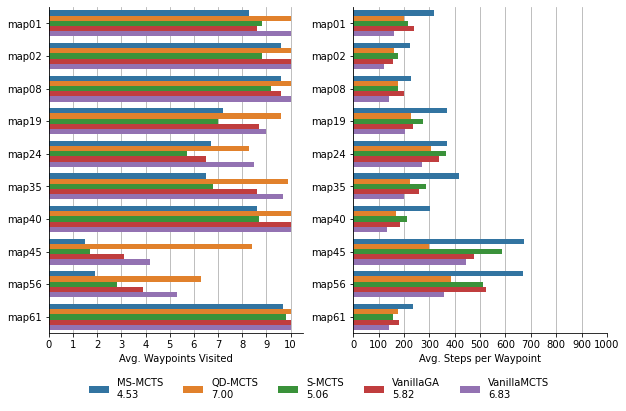

In [5]:
avgWaypoints = {}
avgStepsPerWaypoint = {}
for key in bestRunsDict:
    log = bestRunsDict[key]
    # Shorten map name to only contain contain "map$id$"
    log["ShortenedMapName"] = [getMapName(name) for name in log["MapName"]]

    log["StepsPerWaypoint"] = log["Steps"] / (log["WaypointsVisited"] + 1)
    mapAvg = log.groupby("ShortenedMapName").mean()

    avgWaypoints[key] = mapAvg["WaypointsVisited"]
    avgStepsPerWaypoint[key] = mapAvg["StepsPerWaypoint"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Create plot for avg waypoints visited
avgWaypointDf = pd.DataFrame(avgWaypoints).reset_index()
flatDf = avgWaypointDf.melt(id_vars="ShortenedMapName")
sns.barplot(x="value", y="ShortenedMapName", hue="variable", data=flatDf, ax=ax1)
avgStepsDf = pd.DataFrame(avgStepsPerWaypoint).reset_index()
flatDf = avgStepsDf.melt(id_vars="ShortenedMapName")
sns.barplot(x="value", y="ShortenedMapName", hue="variable", data=flatDf, ax=ax2)

# Configure axis
ax1.set_xticks(range(0, 11))
ax1.set_xlabel("Avg. Waypoints Visited")
ax2.set_xticks(range(0, 1001, 100))
ax2.set_xlabel("Avg. Steps per Waypoint")
for ax in [ax1, ax2]:
    ax.set_ylabel("")
    ax.get_legend().remove()
    ax.grid(True, axis='x')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
# Legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(avgStepsDf.columns), frameon=False)
fig.savefig("optimizedAlgorithms.png", bbox_inches='tight')

# Compare handpicked parameters with best results

In [6]:
hpRunLog, hpOptLog = algLogDict["QD-MCTS"][0]
print(hpOptLog["params"]) # Output should be {'highER': 4.0, 'lowER': 1.4142135623730951, 'rd': 25.0, 'steps': 400.0}

qdDict = {
    "VanillaMCTS" : max(algLogDict["VanillaMCTS"], key=lambda pair: pair[1]["target"])[0],
    "HP-QD-MCTS": hpRunLog,
    "QD-MCTS" : max(algLogDict["QD-MCTS"], key=lambda pair: pair[1]["target"])[0]
}

{'highER': 4.0, 'lowER': 1.4142135623730951, 'rd': 25.0, 'steps': 400.0}


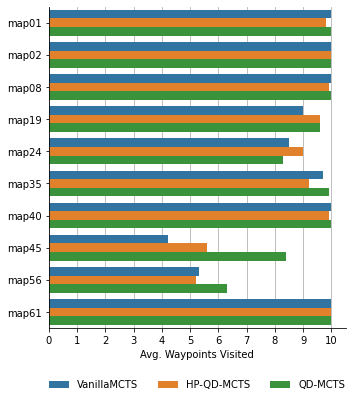

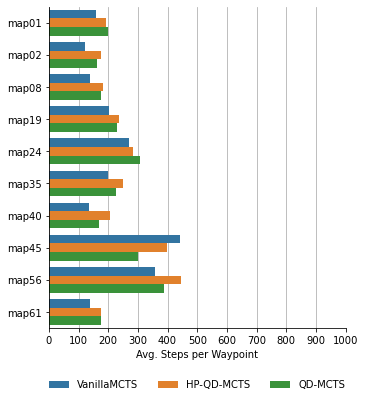

In [7]:
avgWaypoints = {}
avgStepsPerWaypoint = {}
for key in qdDict:
    log = qdDict[key]
    # Shorten map name to only contain contain "map$id$"
    log["ShortenedMapName"] = [getMapName(name) for name in log["MapName"]]

    log["StepsPerWaypoint"] = log["Steps"] / (log["WaypointsVisited"] + 1)
    mapAvg = log.groupby("ShortenedMapName").mean()

    avgWaypoints[key] = mapAvg["WaypointsVisited"]
    avgStepsPerWaypoint[key] = mapAvg["StepsPerWaypoint"]
    
# Create plot for avg waypoints visited
avgWaypointDf = pd.DataFrame(avgWaypoints).reset_index()
flatDf = avgWaypointDf.melt(id_vars="ShortenedMapName")
g1 = sns.catplot(kind="bar", x="value", y="ShortenedMapName", hue="variable", data=flatDf, legend=False)
g1.despine(right=True)
for ax in g1.axes.flat:
    ax.grid(True, axis='x')
    ax.set_axisbelow(True)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol=len(avgWaypointDf.columns), frameon=False)
plt.xticks(range(0, 11))
plt.ylabel("")
plt.xlabel("Avg. Waypoints Visited")
plt.show()

# Create plot for avg steps per waypoint
avgStepsDf = pd.DataFrame(avgStepsPerWaypoint).reset_index()
flatDf = avgStepsDf.melt(id_vars="ShortenedMapName")
g2 = sns.catplot(kind="bar", x="value", y="ShortenedMapName", hue="variable", data=flatDf, legend=False)
g2.despine(right=True)
for ax in g2.axes.flat:
    ax.grid(True, axis='x')
    ax.set_axisbelow(True)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol=len(avgStepsDf.columns), frameon=False)
plt.xticks(range(0, 1001, 100))
plt.ylabel("")
plt.xlabel("Avg. Steps per Waypoint")
plt.show()

g1.savefig("avgWaypointsVisited(HP).png", bbox_inches='tight')
g2.savefig("stepsPerWaypoint(HP).png", bbox_inches='tight')

# Visualize the effect of parameters on QD-MCTS

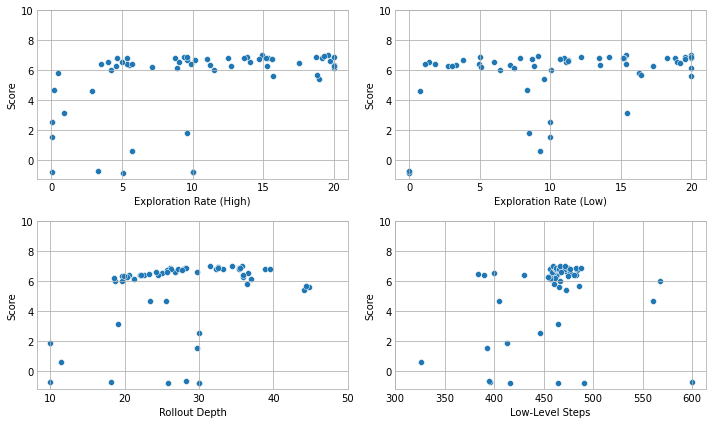

In [4]:
optLogs = [optLog for runLog, optLog in algLogDict["QD-MCTS"]]

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

targets = [log["target"] for log in optLogs]
xTicks = {
    "highER": [0, 5, 10, 15, 20],
    "lowER": [0, 5, 10, 15, 20],
    "rd": [10, 20, 30, 40, 50],
    "steps": [300, 350, 400, 450, 500, 550, 600],
}
xLabel = {
    "highER": "Exploration Rate (High)",
    "lowER": "Exploration Rate (Low)",
    "rd": "Rollout Depth",
    "steps": "Low-Level Steps",
}
for param, ax in zip(["highER", "lowER", "rd", "steps"], axis.flatten()):
    params = [log["params"][param] for log in optLogs]
    
    sns.scatterplot(x=params, y=targets, ax=ax)
    
    ax.grid(True)
    ax.set_clip_on(True)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_xticks(xTicks[param])
    ax.set_ylabel("Score")
    ax.set_xlabel(xLabel[param])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.setp(ax.spines.values(), color=mpl.rcParams['grid.color'])
fig.tight_layout()
fig.savefig("optimized_QDMCTS_params.png", bbox_inches='tight')

# Visualize the parameter influence for all algorithms

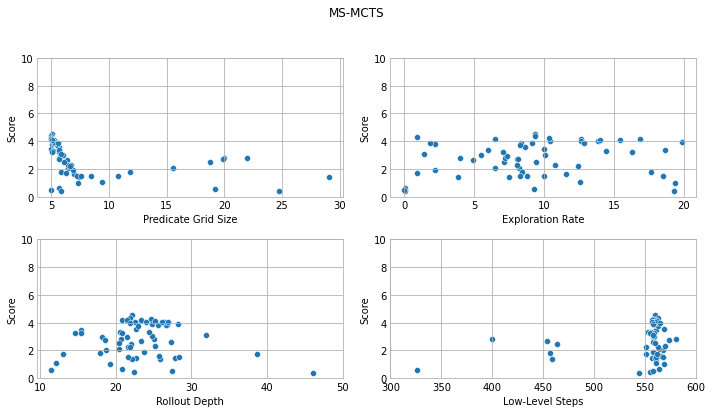

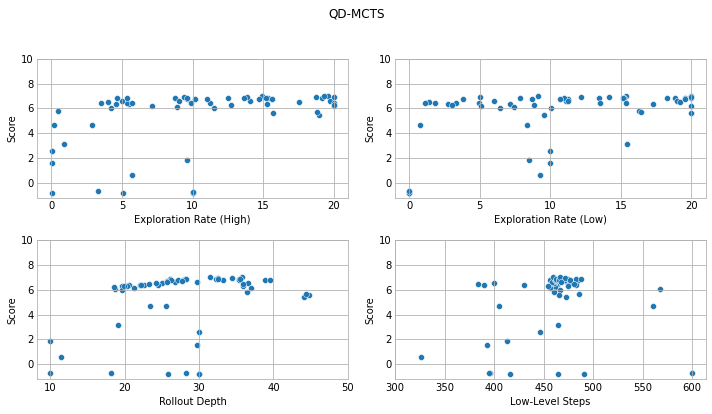

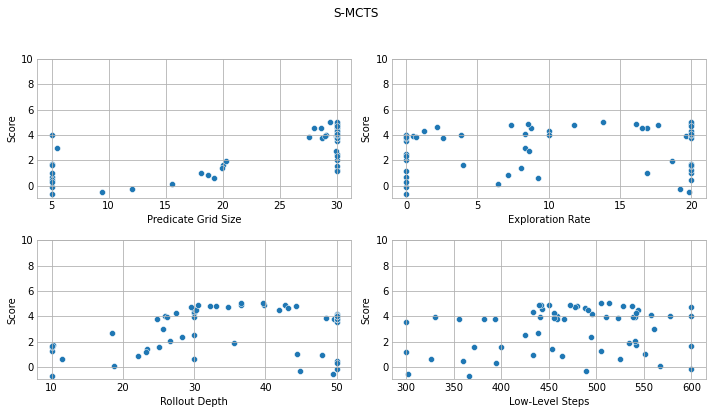

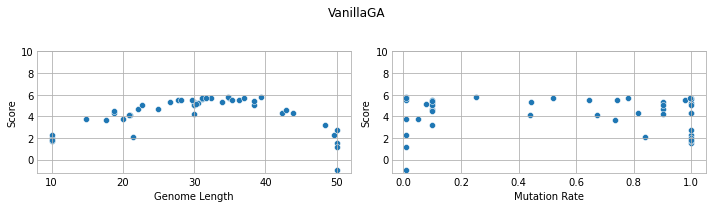

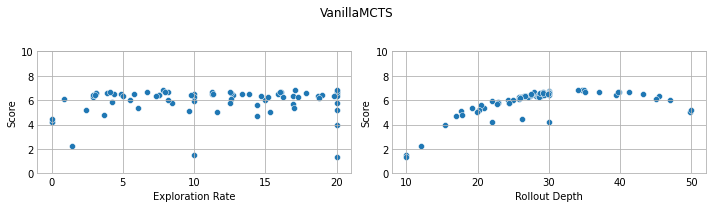

In [10]:
# Parameter specific data for plotting
xTicks = {
    "highER": [0, 5, 10, 15, 20],
    "lowER": [0, 5, 10, 15, 20],
    "rd": [10, 20, 30, 40, 50],
    "steps": [300, 350, 400, 450, 500, 550, 600],
    "cellSize": [5, 10, 15, 20, 25, 30],
    "er": [0, 5, 10, 15, 20],
    "gl": [10, 20, 30, 40, 50],
    "mr": [0, 0.2, 0.4, 0.6, 0.8, 1],
    "ps": [1, 50, 100, 150, 200]
}
xLabel = {
    "highER": "Exploration Rate (High)",
    "lowER": "Exploration Rate (Low)",
    "rd": "Rollout Depth",
    "steps": "Low-Level Steps",
    "cellSize": "Predicate Grid Size",
    "er": "Exploration Rate",
    "gl": "Genome Length",
    "mr": "Mutation Rate",
    "ps": "Population Size"
}

# Create plot for each algorithm
for alg in algLogDict:
    optLogs = [optLog for runLog, optLog in algLogDict[alg]]
    parameters = [key for key in optLogs[0]["params"]]
    
    nrows = len(parameters)//2
    ncols = 2
    figsize = (10, 3 * nrows)
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plt.suptitle(alg)

    targets = [log["target"] for log in optLogs]
    
    for param, ax in zip(parameters, axis.flatten()):
        params = [log["params"][param] for log in optLogs]

        sns.scatterplot(x=params, y=targets, ax=ax)

        ax.grid(True)
        ax.set_clip_on(True)
        ax.set_yticks([0, 2, 4, 6, 8, 10])
        ax.set_xticks(xTicks[param])
        ax.set_ylabel("Score")
        ax.set_xlabel(xLabel[param])
        ax.tick_params(axis=u'both', which=u'both',length=0)
        plt.setp(ax.spines.values(), color=mpl.rcParams['grid.color'])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f"optimized_{alg}_params.png", bbox_inches='tight')